<a href="https://colab.research.google.com/github/8Dis-like/UCLALearning/blob/main/Fall2025_CM146_HW2_HZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2

**Name**: Hao Zhang

**UID**: 206548281

## Preparation (import data and packages)

In [ ]:
# Download a processed version of the data
!wget https://huggingface.co/hk/hw1/resolve/main/mushroom.txt

--2025-11-01 22:27:42--  https://huggingface.co/hk/hw1/resolve/main/mushroom.txt
Resolving huggingface.co (huggingface.co)... 54.230.71.28, 54.230.71.56, 54.230.71.2, ...
Connecting to huggingface.co (huggingface.co)|54.230.71.28|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/hk/hw1/d23e2ca56c2eb67af93a318c77348b936dcf4d12/mushroom.txt?%2Fhk%2Fhw1%2Fresolve%2Fmain%2Fmushroom.txt=&etag=%2212401d069edc9c3b8be14236a657b917ab324a19%22 [following]
--2025-11-01 22:27:43--  https://huggingface.co/api/resolve-cache/models/hk/hw1/d23e2ca56c2eb67af93a318c77348b936dcf4d12/mushroom.txt?%2Fhk%2Fhw1%2Fresolve%2Fmain%2Fmushroom.txt=&etag=%2212401d069edc9c3b8be14236a657b917ab324a19%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mushroom.txt.5’

mushroom.txt.5      100%[===================>]   1.21M  --.-KB/s    in 0.09s   

2025-11

In [ ]:
# Use only the provided packages!
import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the Mushroom dataset

In [ ]:
# load data from txt
# X.shape = (n_examples, n_features), y.shape = (n_examples, )
def load_data(filename):
    data = pandas.read_csv(filename).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1

    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]

    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)

    return X, y

In [ ]:
def create_data(filename, test_size=0.15, val_size=0.15):
    # Load the dataset
    X, y = load_data(filename='mushroom.txt')

    # Split into train, validation, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    X_train, X_val, X_test = torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test)
    y_train = torch.Tensor(np.array([ [y] for y in y_train ]))
    y_val = torch.Tensor(np.array([ [y] for y in y_val ]))
    y_test = torch.Tensor(np.array([ [y] for y in y_test ]))

    return X_train, y_train, X_val, y_val, X_test, y_test

# 3.1 Creating Datasets and DataLoaders

In [ ]:
def get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=16, test_batch_size=32):
    # Create TensorDatasets for train, validation, and test sets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
def evaluate_loss(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    for batch_X, batch_y in dataloader:
        batch_size = len(batch_X)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

    return total_loss / len(dataloader.dataset)

In [ ]:
def evaluate_acc(model, dataloader):
    model.eval()
    total_acc = 0.0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        predictions = (outputs > 0.5).long()
        total_acc += (predictions==batch_y).sum()

    return total_acc / len(dataloader.dataset)

# 3.2 One Layer Neural Network

In [ ]:
import torch.nn as nn
######################################################################
# OneLayerNetwork -- ALSO A LOGISTIC REGRESSION MODEL
######################################################################

class OneLayerNetwork(torch.nn.Module):
    def __init__(self, input_features):
        # input_features: int
        super(OneLayerNetwork, self).__init__()

        # Define a single fully connected layer
        self.fc1 = nn.Linear(input_features, 1)

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        outputs = torch.sigmoid(self.fc1(x))

        return outputs

In [ ]:
def init_oneLayerNN(in_features, lr):
    # input_features: int -> Number of input features
    # lr: float -> Learning Rate

    # 1. Create an instance of the model
    model = OneLayerNetwork(input_features=in_features)

    # 2. Define the loss criterion (Binary Cross Entropy) with reduction='sum'
    criterion = torch.nn.BCELoss(reduction='sum')

    # 3. Define the optimizer (Stochastic Gradient Descent)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, criterion, optimizer

# 3.3 Two Layer Neural Network

In [ ]:
######################################################################
# TwoLayerNetwork
######################################################################

class TwoLayerNetwork(torch.nn.Module):
    def __init__(self, input_features, hidden_features, first_activation='sigmoid'):
        # input_features: int -> Number of input features
        # hidden_features: int -> Size of the hidden layer
        # first_activation: str -> Activation to use for the first hidden layer

        super(TwoLayerNetwork, self).__init__()

        # Define two fully connected layers
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, 1)

        # Save activation type (optional flexibility)
        self.first_activation = first_activation

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        # Apply activation to first layer
        if self.first_activation == 'sigmoid':
            hidden = torch.sigmoid(self.fc1(x))
        elif self.first_activation == 'relu':
            hidden = torch.relu(self.fc1(x))
        else:
            raise ValueError(f"Unsupported activation: {self.first_activation}")

        # Second layer with sigmoid activation
        outputs = torch.sigmoid(self.fc2(hidden))

        return outputs

In [ ]:
def init_twoLayerNN(in_features, hidden_size, first_activation, lr):
    # input_features: int -> Number of input features
    # hidden_features: int -> Size of the hidden layer
    # first_activation: str -> Activation to use for the first hidden layer
    # lr: float -> Learning Rate

    # 1. Create an instance of the TwoLayerNetwork
    model = TwoLayerNetwork(
        input_features=in_features,
        hidden_features=hidden_size,
        first_activation=first_activation
    )

    # 2. Define the loss criterion (Binary Cross Entropy) with reduction='sum'
    criterion = torch.nn.BCELoss(reduction='sum')

    # 3. Define the optimizer (Stochastic Gradient Descent)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    return model, criterion, optimizer

# 3.4 Training the Model

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, logging_epochs=1):
    print("Start training model...")

    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for epoch in range(1, num_epochs+1):
        model.train()
        for batch_X, batch_y in train_loader:
            # 1. Zero out gradients from previous step
            optimizer.zero_grad()

            # 2. Forward pass
            outputs = model(batch_X)

            # 3. Compute loss
            loss = criterion(outputs, batch_y)

            # 4. Backward pass (compute gradients)
            loss.backward()

            # 5. Update model parameters
            optimizer.step()

        train_loss = evaluate_loss(model, criterion, train_loader)
        valid_loss = evaluate_loss(model, criterion, valid_loader)
        train_acc = evaluate_acc(model, train_loader)
        valid_acc = evaluate_acc(model, valid_loader)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        if logging_epochs > 0 and epoch % logging_epochs == 0:
            print(f"| epoch {epoch:2d} | train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

In [ ]:
# fix random seed
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Data Preparation
train_batch_size = 16
test_batch_size = 32

## Load data
X_train, y_train, X_val, y_val, X_test, y_test = create_data("mushroom.txt")

## Create data loaders
train_loader, val_loader, test_loader = get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

In [ ]:
## Define hyperparameters
lr = 0.001
num_epochs = 50

## Init models
oneLayerNN, criterion, optimizer = init_oneLayerNN(X_train.shape[1], lr=lr)
results_one = train(oneLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.557378 | train acc 0.715414 | valid loss 0.559479 | valid acc 0.715750 |
| epoch  2 | train loss 0.546404 | train acc 0.727093 | valid loss 0.543314 | valid acc 0.736253 |
| epoch  3 | train loss 0.534622 | train acc 0.735976 | valid loss 0.534198 | valid acc 0.749301 |
| epoch  4 | train loss 0.536712 | train acc 0.739102 | valid loss 0.542148 | valid acc 0.743709 |
| epoch  5 | train loss 0.528689 | train acc 0.733838 | valid loss 0.534176 | valid acc 0.735322 |
| epoch  6 | train loss 0.528647 | train acc 0.768218 | valid loss 0.535205 | valid acc 0.770736 |
| epoch  7 | train loss 0.524880 | train acc 0.758184 | valid loss 0.531868 | valid acc 0.759553 |
| epoch  8 | train loss 0.530940 | train acc 0.742556 | valid loss 0.535152 | valid acc 0.751165 |
| epoch  9 | train loss 0.521009 | train acc 0.757526 | valid loss 0.528466 | valid acc 0.762349 |
| epoch 10 | train loss 0.523456 | train acc 0.752097 | valid loss 0.530420 | valid a

In [ ]:
## Define hyperparameters
lr = 0.001
hidden_size = 6
activation = 'sigmoid'
num_epochs = 50

## Init models
twoLayerNN, criterion, optimizer = init_twoLayerNN(X_train.shape[1], hidden_size, activation, lr=lr)
results_two = train(twoLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.678097 | train acc 0.525909 | valid loss 0.674994 | valid acc 0.557316 |
| epoch  2 | train loss 0.663843 | train acc 0.610956 | valid loss 0.662280 | valid acc 0.623486 |
| epoch  3 | train loss 0.647194 | train acc 0.620003 | valid loss 0.643383 | valid acc 0.630941 |
| epoch  4 | train loss 0.626839 | train acc 0.685475 | valid loss 0.621754 | valid acc 0.691519 |
| epoch  5 | train loss 0.601474 | train acc 0.714591 | valid loss 0.596573 | valid acc 0.719478 |
| epoch  6 | train loss 0.574962 | train acc 0.754565 | valid loss 0.570228 | valid acc 0.767008 |
| epoch  7 | train loss 0.551367 | train acc 0.743708 | valid loss 0.548664 | valid acc 0.753961 |
| epoch  8 | train loss 0.533270 | train acc 0.751275 | valid loss 0.531942 | valid acc 0.757689 |
| epoch  9 | train loss 0.520149 | train acc 0.755058 | valid loss 0.520067 | valid acc 0.759553 |
| epoch 10 | train loss 0.509807 | train acc 0.763119 | valid loss 0.510060 | valid a

# 3.5 Putting it all together

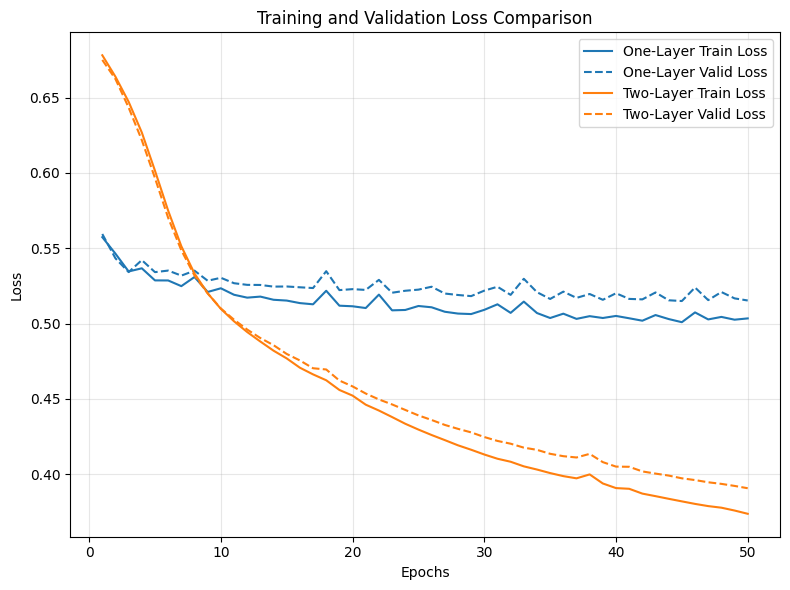

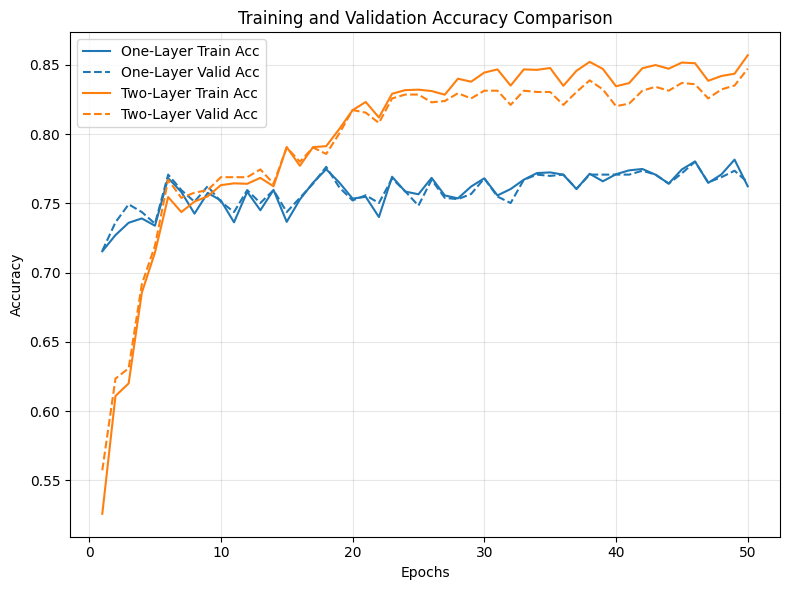

In [ ]:
import matplotlib.pyplot as plt
one_train_loss, one_valid_loss, one_train_acc, one_valid_acc = results_one
two_train_loss, two_valid_loss, two_train_acc, two_valid_acc = results_two
epochs = range(1, len(one_train_loss) + 1)
### ========== TODO : START ========== ###
### part h: Plot the loss for training/validation for both models on the same figure
plt.figure(figsize=(8, 6))
plt.plot(epochs, one_train_loss, label='One-Layer Train Loss', color='tab:blue', linestyle='-')
plt.plot(epochs, one_valid_loss, label='One-Layer Valid Loss', color='tab:blue', linestyle='--')
plt.plot(epochs, two_train_loss, label='Two-Layer Train Loss', color='tab:orange', linestyle='-')
plt.plot(epochs, two_valid_loss, label='Two-Layer Valid Loss', color='tab:orange', linestyle='--')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### part h: Plot the accuracies for training/validation for both the models on the same curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, one_train_acc, label='One-Layer Train Acc', color='tab:blue', linestyle='-')
plt.plot(epochs, one_valid_acc, label='One-Layer Valid Acc', color='tab:blue', linestyle='--')
plt.plot(epochs, two_train_acc, label='Two-Layer Train Acc', color='tab:orange', linestyle='-')
plt.plot(epochs, two_valid_acc, label='Two-Layer Valid Acc', color='tab:orange', linestyle='--')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate test accuracy of one-layer network
one_test_acc = evaluate_acc(oneLayerNN, test_loader)

# Evaluate test accuracy of two-layer network
two_test_acc = evaluate_acc(twoLayerNN, test_loader)

print(f"Test Accuracy (One-Layer Network): {one_test_acc:.4f}")
print(f"Test Accuracy (Two-Layer Network): {two_test_acc:.4f}")

Test Accuracy (One-Layer Network): 0.7664
Test Accuracy (Two-Layer Network): 0.8416


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, dataloader):
    ### part j: Create confusion matrix for the given data loader

    model.eval()  # switch to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()  # threshold sigmoid output
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # flatten all collected predictions and labels
    all_preds = np.vstack(all_preds).ravel()
    all_labels = np.vstack(all_labels).ravel()

    # compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return cm

In [ ]:
oneLayerNN_cm = get_confusion_matrix(oneLayerNN, val_loader)
twoLayerNN_cm = get_confusion_matrix(twoLayerNN, val_loader)

print ("Confusion Matrix for One Layer NN")
print (oneLayerNN_cm)

print ("Confusion Matrix for Two Layer NN")
print (twoLayerNN_cm)

Confusion Matrix for One Layer NN
[[402 120]
 [132 419]]
Confusion Matrix for Two Layer NN
[[405 117]
 [ 47 504]]


In [ ]:
import itertools

# Define search space
hidden_sizes = [8, 16, 32]
learning_rates = [0.001, 0.01, 0.05]
activations = ['sigmoid', 'relu']

best_acc = 0
best_params = None
results = []

for hidden, lr, act in itertools.product(hidden_sizes, learning_rates, activations):
    print(f"Testing: hidden={hidden}, lr={lr}, act={act}")

    # Initialize model, loss, optimizer
    model, criterion, optimizer = init_twoLayerNN(
        in_features=X_train.shape[1],
        hidden_size=hidden,
        first_activation=act,
        lr=lr
    )

    # Train
    results_two = train(model, criterion, optimizer, train_loader, val_loader, num_epochs=50)
    _, _, _, valid_acc = results_two
    val_final_acc = valid_acc[-1]
    results.append((hidden, lr, act, val_final_acc))

    # Track best
    if val_final_acc > best_acc:
        best_acc = val_final_acc
        best_params = (hidden, lr, act)

print("\nBest configuration:")
print(f"Hidden Size: {best_params[0]}, Learning Rate: {best_params[1]}, Activation: {best_params[2]}")
print(f"Validation Accuracy: {best_acc:.4f}")

# Combine train + val sets for final training
X_final = torch.cat([X_train, X_val])
y_final = torch.cat([y_train, y_val])

final_train_loader, _, test_loader = get_dataloaders(X_final, y_final, X_val, y_val, X_test, y_test)

# Re-initialize with best hyperparameters
best_model, criterion, optimizer = init_twoLayerNN(
    in_features=X_train.shape[1],
    hidden_size=best_params[0],
    first_activation=best_params[2],
    lr=best_params[1]
)

# Train final model
results_final = train(best_model, criterion, optimizer, final_train_loader, val_loader, num_epochs=50)

# Evaluate on test set
best_test_acc = evaluate_acc(best_model, test_loader)
print(f"Final Test Accuracy: {best_test_acc:.4f}")

hidden_size = 16
learning_rate = 0.01
first_activation = 'relu'
num_epochs = 100



Testing: hidden=8, lr=0.001, act=sigmoid
Start training model...
| epoch  1 | train loss 0.667617 | train acc 0.597631 | valid loss 0.669444 | valid acc 0.581547 |
| epoch  2 | train loss 0.643339 | train acc 0.659319 | valid loss 0.642233 | valid acc 0.659832 |
| epoch  3 | train loss 0.617020 | train acc 0.703899 | valid loss 0.614175 | valid acc 0.706431 |
| epoch  4 | train loss 0.590427 | train acc 0.729232 | valid loss 0.589307 | valid acc 0.732526 |
| epoch  5 | train loss 0.566524 | train acc 0.737621 | valid loss 0.566548 | valid acc 0.738117 |
| epoch  6 | train loss 0.544743 | train acc 0.751275 | valid loss 0.543946 | valid acc 0.752097 |
| epoch  7 | train loss 0.529226 | train acc 0.769205 | valid loss 0.531646 | valid acc 0.767008 |
| epoch  8 | train loss 0.514784 | train acc 0.769370 | valid loss 0.518159 | valid acc 0.769804 |
| epoch  9 | train loss 0.502327 | train acc 0.760322 | valid loss 0.504905 | valid acc 0.763281 |
| epoch 10 | train loss 0.493433 | train acc